In [135]:
# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

import sklearn
import pandas as pd
# import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'clf', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [136]:
# Загружаем данные из файлов
train = pd.read_csv('./titanic/train.csv', sep=',', header=0)
test = pd.read_csv('./titanic/test.csv',sep=',', header=0)

Обьеденим данные в один класс для удобства обработки

In [137]:
DROP_COL = ['PassengerId','Ticket','Cabin']
TARGET_COL = 'Survived'
DROP_COL

['PassengerId', 'Ticket', 'Cabin']

In [138]:
# вытащим целевую переменную
Y=train.Survived
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [139]:
# посмотрим кто коррелируется с целевой переменной
corr_matrix = train.corr()
corr_matrix['PassengerId'].sort_values(ascending=False)


PassengerId    1.000000
Age            0.036847
Fare           0.012658
Parch         -0.001652
Survived      -0.005007
Pclass        -0.035144
SibSp         -0.057527
Name: PassengerId, dtype: float64

In [140]:
Xtrain = train.drop(DROP_COL+ [TARGET_COL], axis=1)

Xtest = test.drop(DROP_COL, axis=1)

Xtrain['is_test'] = False
Xtest['is_test'] = True

X = pd.concat([Xtrain, Xtest], axis=0)

X.index = range(len(X))
X.head()


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,is_test
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,False
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,False
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,False
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,False
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,False


In [141]:
# переведем категориальные в нормальные для Pclass, Sex, Embarked drop_first = True
X = pd.get_dummies(X, columns=['Sex'],drop_first = True)
X = pd.get_dummies(X, columns=['Pclass', 'Embarked'])
X.head()

,Name,Age,SibSp,Parch,Fare,is_test,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,False,1,0,0,1,0,0,1
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,False,0,1,0,0,1,0,0
2,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,False,0,0,0,1,0,0,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,False,0,1,0,0,0,0,1
4,"Allen, Mr. William Henry",35.0,0,0,8.0500,False,1,0,0,1,0,0,1


In [142]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Name          1309 non-null object
Age           1046 non-null float64
SibSp         1309 non-null int64
Parch         1309 non-null int64
Fare          1308 non-null float64
is_test       1309 non-null bool
Sex_male      1309 non-null uint8
Pclass_1      1309 non-null uint8
Pclass_2      1309 non-null uint8
Pclass_3      1309 non-null uint8
Embarked_C    1309 non-null uint8
Embarked_Q    1309 non-null uint8
Embarked_S    1309 non-null uint8
dtypes: bool(1), float64(2), int64(2), object(1), uint8(7)
memory usage: 61.4+ KB


## уберем пропуски

In [143]:
# по возрасту берем среднее
X.loc[pd.isnull( X['Age'] ) & (X['Sex_male'] == 1),'Age']=X[(X['Sex_male'] == 1)].Age.mean()
X.loc[pd.isnull( X['Age'] ) & (X['Sex_male'] == 0),'Age']=X[(X['Sex_male'] == 0)].Age.mean()

# по тарифу берем срденее по классу
X.loc[pd.isnull( X ['Fare']),'Fare']=X [(X ['Pclass_3'] == 1)].Fare.mean()

## Вытащим из имени статус

In [144]:
#сделаем просто: соединим все описания в один большой текст и посчитаем в нём вхождение каждого слова. 
#Флаги наличия самых популярных и включим как фичи
from collections import Counter

In [152]:
one_big_text = " ".join(X.Name)
words = one_big_text.split()
most_common = Counter(words).most_common()
most_common[:30]

[('Mr#', 757),
 ('Miss#', 260),
 ('Mrs#', 197),
 ('William', 85),
 ('John', 72),
 ('Master#', 61),
 ('Henry', 47),
 ('Charles', 38),
 ('James', 37),
 ('George', 35),
 ('Joseph', 31),
 ('Thomas', 31),
 ('Edward', 28),
 ('Johan', 22),
 ('Frederick', 20),
 ('Samuel', 20),
 ('Arthur', 20),
 ('Alfred', 18),
 ('Alexander', 17),
 ('Robert', 17),
 ('Elizabeth', 16),
 ('Mary', 16),
 ('Richard', 15),
 ('Albert', 14),
 ('Jr', 14),
 ('Karl', 14),
 ('J', 13),
 ('Maria', 13),
 ('Frank', 13),
 ('Ernest', 12)]

In [153]:
# включим столбцы mr/miss/mrs
X.Name=X.Name.str.replace(".", "#")

X['is_Mr'] = X.Name.str.contains('Mr#').astype(int) | X.Name.str.contains('Master#').astype(int) | X.Name.str.contains('Dr#').astype(int)
X['is_Miss'] = X.Name.str.contains('Miss#').astype(int) | X.Name.str.contains('Mlle#').astype(int) | X.Name.str.contains('Ms#').astype(int)
X['is_Mrs'] = X.Name.str.contains('Mrs#').astype(int)



In [150]:
X.drop(['Name'], axis=1, inplace=True)
X.head()

,Name,Age,SibSp,Parch,Fare,is_test,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,is_Mr,is_Miss,is_Mrs
0,"Braund, Mr# Owen Harris",22.0,1,0,7.2500,False,1,0,0,1,0,0,1,1,0,0
1,"Cumings, Mrs# John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,False,0,1,0,0,1,0,0,0,0,1
2,"Heikkinen, Miss# Laina",26.0,0,0,7.9250,False,0,0,0,1,0,0,1,0,1,0
3,"Futrelle, Mrs# Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,False,0,1,0,0,0,0,1,0,0,1
4,"Allen, Mr# William Henry",35.0,0,0,8.0500,False,1,0,0,1,0,0,1,1,0,0


In [102]:
# проверим на пропуски!
X.isnull().sum()

Age           0
SibSp         0
Parch         0
Fare          0
is_test       0
Sex_male      0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
is_Mr         0
is_Miss       0
is_Mrs        0
dtype: int64

# c Данными закончили, 

In [103]:
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler

In [113]:
#  разделим данные на части !!

X_train = X[~X.is_test].drop(['is_test'], axis=1)
X_test = X[X.is_test].drop(['is_test'], axis=1)

# сделаем скеёлинг
#SK=StandardScaler().fit(X_train)
#X_train=SK.transform(X_train)
#X_test=SK.transform(X_train)


(891, 14)


# RANDOM FOREST


In [114]:
# Устанавливаем аргумент warm_start=True для дообучения модели
# ПОДБЕРЕМ различные параметры

RANDOM_STATE=12345

ensemble_clfs = [
    ("RandomForestClassifier, max_features=7-3",
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features=7,
                               max_depth=3,
                               n_jobs=-1,    
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=7-4",
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features=7,
                               max_depth=4,
                               n_jobs=-1,
                               random_state=RANDOM_STATE)),
    
  ("RandomForestClassifier, max_features=7-6",
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features=7,
                               max_depth=6,
                               n_jobs=-1,
                               random_state=RANDOM_STATE)),
    
    ("RandomForestClassifier, max_features=7-8",    # BEST MODEL
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features=7,
                               max_depth=8,
                               n_jobs=-1,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=7-10",    
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features=7,
                               max_depth=10,
                               n_jobs=-1,
                              random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=7-12",    
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features=7,
                               max_depth=12,
                               n_jobs=-1,
                              random_state=RANDOM_STATE))
]

In [115]:
from collections import OrderedDict
# Создаем переменную для сохранения оценки качества на каждой итерации
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Диапазон значений числа базовых деревьев
min_estimators = 20
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators+1,1):
        # Задаем число 
        clf.set_params(n_estimators=i)
        clf.fit(X_train, Y)

        # Сохра
        oob_error = 1-clf.oob_score_
        error_rate[label].append((i, oob_error))

#print(error_rate)

In [107]:
# Выводим зависимость качества от числа базовых моделей
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
#ПОСМОТРИМ ЧТО РЕКОМЕНДУЮТ
error_rate['RandomForestClassifier, max_features=7-8']

In [ ]:
# Находим оптимальное число итераций на тесте возьмеме  85
print(np.argmin(error_rate['RandomForestClassifier, max_features=7-8']), np.min(error_rate['RandomForestClassifier, max_features=7-8']))

In [ ]:
# отправим в Kaggel для дальнейшего сравнения
#TempCL = RandomForestClassifier(max_features=7,max_depth=8, n_estimators=85).fit(X_train, Y)  --- лучший результат
#predicted = TempCL.predict(X_test)

#with open('submission.txt', 'w') as out:
#    out.write('PassengerId,Survived\n')
#    for passenger, y in zip(test['PassengerId'], predicted):
#        out.write('%s,%s\n' % (passenger, y))

## GradientBoostingClassifier

In [109]:
# Разбиваем выборку на обучение и тест
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, 
                                                        Y,
                                                        test_size=0.25, 
                                                        random_state=RANDOM_STATE)

ValueError: Found input variables with inconsistent numbers of samples: [1309, 891]

In [ ]:
# вначале для подбора гиперпараметров
depths_t = np.arange(2,7)
features_t= np.array([0.5,0.75,1])
leaf_t= np.array([1,2,3,4])
est_t= np.arange(1,50)

grid = {'max_depth': depths_t, 'max_features': features_t, 'min_samples_leaf':leaf_t,'n_estimators':est_t}

In [ ]:
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(GradientBoostingClassifier(presort=True, warm_start=True), grid, scoring='neg_log_loss', cv=4)

In [ ]:
model = gridsearch.fit(X_train, Y)

In [ ]:
# посмотрим на рекомендованные параметры
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

In [ ]:
LEARNING_RATE = 0.05
MAX_DEPTH = 6
SUBSAMPLE = 0.5
MAX_FEATURES = 0.5
LEAF = 1
NEST=100

# Создаем класс модели градиентного бустинга
clf = GradientBoostingClassifier(n_estimators=NEST
                                 , 
                                 #learning_rate=LEARNING_RATE,
                                 #max_depth=MAX_DEPTH, 
                                 #subsample=SUBSAMPLE,
                                 #max_features=MAX_FEATURES,
                                 #min_samples_leaf=LEAF
                                )

# Обучаем модель на обучающей выборке
clf.fit(X_train_,  y_train_)

test_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict_proba(X_test_)):
    test_score[i] = log_loss(y_test_, y_pred)
    
train_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict_proba(X_train_)):
    train_score[i] = log_loss(y_train_, y_pred)

# Находим оптимальное число итераций на тесте
print(np.argmin(test_score), np.min(test_score))

# Выводим зависимость качества от числа итераций
plt.plot(range(len(train_score)), train_score, 'b-',
         range(len(test_score)), test_score, 'r-')

In [ ]:
# c подбор параметров
# по умолчанию
#28 0.475189796813

#'max_depth': 3, 'max_features': 0.5, 'min_samples_leaf': 1
#24 0.489614338636

#'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 25},
#23 0.473230451851

In [ ]:
# отправим в Kaggel для дальнейшего сравнения
#TempCL = GradientBoostingClassifier(max_features=0.5,max_depth=6, n_estimators=25, min_samples_leaf=1).fit(X_train, Y)  # лучший результат
#TempCL = GradientBoostingClassifier(n_estimators=24).fit(X_train, Y)  # лучший результат
#predicted = TempCL.predict(X_test)

#with open('submission.txt', 'w') as out:
#    out.write('PassengerId,Survived\n')
#    for passenger, y in zip(test['PassengerId'], predicted):
#        out.write('%s,%s\n' % (passenger, y))

## Добавим SVM

In [32]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
# вначале для подбора гиперпараметров
C_t= np.array([0.05,0.1,1,10])
#C_t=np.arange(0.1,10,0.1)
#alg_t= ['linear','poly','rbf']
alg_t= ['linear','rbf']
grid = {'kernel': alg_t, 'C': C_t}
#grid = {'C': C_t}
#gridsearch = GridSearchCV(SVC(), grid, scoring='accuracy', cv=4)

gridsearch = GridSearchCV(SVC(), grid, scoring='accuracy', cv=ShuffleSplit(n_splits=4, test_size=0.2, random_state=42))

# посмотрим на рекомендованные параметры
X_train_sc=StandardScaler().fit_transform(X_train)
model = gridsearch.fit(X_train_sc, Y)
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.84078, std: 0.02545, params: {'C': 1.0, 'kernel': 'rbf'},
 mean: 0.83380, std: 0.03671, params: {'C': 0.10000000000000001, 'kernel': 'rbf'},
 mean: 0.83101, std: 0.03095, params: {'C': 10.0, 'kernel': 'linear'},
 mean: 0.82821, std: 0.03314, params: {'C': 1.0, 'kernel': 'linear'},
 mean: 0.82682, std: 0.01853, params: {'C': 10.0, 'kernel': 'rbf'},
 mean: 0.82263, std: 0.03497, params: {'C': 0.050000000000000003, 'kernel': 'rbf'},
 mean: 0.81844, std: 0.03317, params: {'C': 0.10000000000000001, 'kernel': 'linear'},
 mean: 0.81425, std: 0.03452, params: {'C': 0.050000000000000003, 'kernel': 'linear'}]

In [35]:
# отправим в Kaggel для дальнейшего сравнения
#TempCL = GradientBoostingClassifier(max_features=0.5,max_depth=6, n_estimators=25, min_samples_leaf=1).fit(X_train, Y)  # лучший результат
#TempCL = GradientBoostingClassifier(n_estimators=24).fit(X_train, Y)  # лучший результат
X_train_sc=StandardScaler().fit_transform(X_train)
TempCL =SVC(C=1,kernel='rbf').fit(X_train_sc, Y)
predicted = TempCL.predict(X_test)

with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))

## попробуем собрать стеккинг

In [116]:
from sklearn.svm import SVC
def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state = None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')


# инициализирем модели с подобранными гиперпараметрами
rf_estimator = RandomForestClassifier(n_jobs=-1,max_features=7,max_depth=8, n_estimators=85)
gb_estimator = GradientBoostingClassifier(n_estimators=24)
sv_estimator = SVC(C=7,kernel='linear',probability=True)

In [117]:
print(X_train.shape)
print(Y.shape)

(891, 14)
(891,)


In [118]:
# получаем предсказания вероятностей ансамблей на кросс-валидации для обучающей выборки
rf_train_pred = cross_val_predict_proba(rf_estimator, X_train, Y)
gb_train_pred = cross_val_predict_proba(gb_estimator, X_train, Y)
sv_train_pred = cross_val_predict_proba(sv_estimator, X_train, Y)

X_train_stack = np.stack([rf_train_pred[:,1], gb_train_pred[:,1], sv_train_pred[:,1] ], axis=1)
X_train_stack_Y = np.stack([rf_train_pred[:,1], gb_train_pred[:,1], sv_train_pred[:,1], Y.values], axis=1)

In [119]:
# получаем предсказания ансамблей для тестовой выборки
rf_test_pred = rf_estimator.fit(X_train, Y).predict_proba(X_test)
gb_test_pred = gb_estimator.fit(X_train, Y).predict_proba(X_test)
sv_test_pred = sv_estimator.fit(X_train, Y).predict_proba(X_test)

X_test_stack = np.stack([rf_test_pred[:,1], gb_test_pred[:,1], sv_test_pred[:,1]], axis=1)

In [120]:
#  посмотрим кто где ошибается и на сколько
df_comp=pd.DataFrame(X_train_stack_Y,columns=['rf','gb','sv','y'])

# сделаем матрицу корреляции
corr_matrix = df_comp.corr()
corr_matrix['y'].sort_values(ascending=False)

y     1.000000
rf    0.679865
gb    0.679166
sv    0.618610
Name: y, dtype: float64

In [121]:
df_comp[((df_comp['rf']<0.5) | (df_comp['gb']<0.5) | (df_comp['sv']<0.5) ) & (df_comp['y']==1)  ] 

#df_comp[((df_comp['gb']<0.5) & (df_comp['rf']>=0.5)) & (df_comp['y']==)  ]  # rf 314 / gb - 306

#  оба ошибаются 0-0-1 87  // 1-1-0 -44
#  rf  обибается 0-12  1-1  ---- видимо преобучается !!! 
#  gb  обибается 0-13  1-10

,rf,gb,sv,y
2,0.629613,0.389237,0.710604,1.0
8,0.662586,0.489785,0.739381,1.0
17,0.071101,0.143830,0.166531,1.0
21,0.032560,0.138054,0.185852,1.0
23,0.359504,0.262691,0.222196,1.0
25,0.100455,0.255123,0.336282,1.0
36,0.029403,0.117138,0.159147,1.0
39,0.461444,0.592094,0.681564,1.0
55,0.284046,0.282016,0.214511,1.0
65,0.568746,0.455767,0.598891,1.0


In [122]:
df_comp=pd.DataFrame(X_train_stack_Y,columns=['rf','gb','sv','y'])

def valuation_formula(x, y):
    if (y==1.0) & (x>=0.5): 
        return 1.0
    elif (y==0.0) & (x<0.5):
        return 1
    else:
        return 0

df_comp['rf+']=df_comp.apply(lambda row: valuation_formula(row['rf'], row['y']), axis=1) 
df_comp['gb+']=df_comp.apply(lambda row: valuation_formula(row['gb'], row['y']), axis=1) 
df_comp['sv+']=df_comp.apply(lambda row: valuation_formula(row['sv'], row['y']), axis=1)
df_comp.head(10)

,rf,gb,sv,y,rf+,gb+,sv+
0,0.126907,0.132252,0.111221,0.0,1.0,1.0,1.0
1,1.000000,0.894586,0.832014,1.0,1.0,1.0,1.0
2,0.629613,0.389237,0.710604,1.0,1.0,0.0,1.0
3,1.000000,0.898881,0.780045,1.0,1.0,1.0,1.0
4,0.140398,0.138054,0.115700,0.0,1.0,1.0,1.0
5,0.079090,0.145572,0.133609,0.0,1.0,1.0,1.0
6,0.139189,0.175137,0.160561,0.0,1.0,1.0,1.0
7,0.302713,0.585474,0.367059,0.0,1.0,0.0,1.0
8,0.662586,0.489785,0.739381,1.0,1.0,0.0,1.0
9,0.910000,0.896810,0.801288,1.0,1.0,1.0,1.0


In [123]:
# веберем когда ошибаются все
df_comp[(df_comp['rf+']==0) | (df_comp['gb+']==0) | (df_comp['sv+']==0) ] 

# сделаем агрегированную матрицу ошибок
print(df_comp['rf+'].sum(),'rf+' )
print(df_comp['gb+'].sum(), 'gb+')
print(df_comp['sv+'].sum(), 'sv+')

740.0 rf+
733.0 gb+
722.0 sv+


## Объединяем предсказания ансамблей с помощью логистической регрессии

In [126]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
#c_values = np.logspace(-2, 3, 200)
c_values=np.array([2,10,100])

logit_searcher = LogisticRegressionCV(Cs=c_values,  cv=skf, verbose=1, n_jobs=-1, penalty='l1')
logit_searcher.fit(X_train_stack, Y)

for key in logit_searcher.scores_[1]:
    print(key, key)
print (logit_searcher.Cs)


[ 0.79017857  0.78125     0.78571429] [ 0.79017857  0.78125     0.78571429]
[ 0.81165919  0.8161435   0.80717489] [ 0.81165919  0.8161435   0.80717489]
[ 0.86936937  0.85585586  0.86036036] [ 0.86936937  0.85585586  0.86036036]
[ 0.84234234  0.83783784  0.83333333] [ 0.84234234  0.83783784  0.83333333]
[  2  10 100]


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.5s finished


In [127]:
from sklearn.model_selection import GridSearchCV
depths = np.arange(0.1,10,0.1)
pen=('l1','l2')
#features_num = np.arange(5,15)
grid = {'C': depths, 'penalty':pen}#, 'max_features': features_num}
model00 = LogisticRegression(n_jobs=-1)
gridsearch = GridSearchCV(model00, grid, scoring='accuracy', cv=4)
gridsearch.fit(X_train_stack, Y)
sorted(gridsearch.grid_scores_, key = lambda x: -x.mean_validation_score)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.83277, std: 0.01664, params: {'C': 0.20000000000000001, 'penalty': 'l2'},
 mean: 0.83165, std: 0.02477, params: {'C': 0.10000000000000001, 'penalty': 'l1'},
 mean: 0.83165, std: 0.01702, params: {'C': 0.10000000000000001, 'penalty': 'l2'},
 mean: 0.83165, std: 0.02240, params: {'C': 0.80000000000000004, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02217, params: {'C': 0.30000000000000004, 'penalty': 'l1'},
 mean: 0.83053, std: 0.01657, params: {'C': 0.30000000000000004, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02110, params: {'C': 0.5, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02110, params: {'C': 0.59999999999999998, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02362, params: {'C': 1.4000000000000001, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02362, params: {'C': 1.5000000000000002, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02362, params: {'C': 1.6000000000000001, 'penalty': 'l2'},
 mean: 0.83053, std: 0.02362, params: {'C': 1.7000000000000002, 'penalty': 'l2'},
 mean: 0.82941, std: 0.0

In [49]:
# посмотрим на рекомендованные параметры
#sorted(logit_searcher.scores_, key = lambda x: -x.mean_validation_score)
#sorted(logit_searcher.scores_, key = lambda x: -x.mea
#print(logit_searcher.scores_[1])
for key in logit_searcher.scores_[1]:
    print(key, key.mean())
print (logit_searcher.Cs)
#logit_searcher
#print ('Max auc_roc:', logit_searcher.scores_[1].max())

[ 0.8206278   0.82735426  0.83183857] 0.826606875934
[ 0.84269663  0.8494382   0.84719101] 0.846441947566
[  2  10 100]


In [128]:
# посмотрим улучшили ли мы предсказание добавив SVM
X_train_, X_test_, Y_train, Y_test = train_test_split(X_train_stack, Y, test_size = 0.33, random_state=None )

In [129]:
print(X_train_.shape, X_test_.shape, Y_train.shape,Y_test.shape)

(596, 3) (295, 3) (596,) (295,)


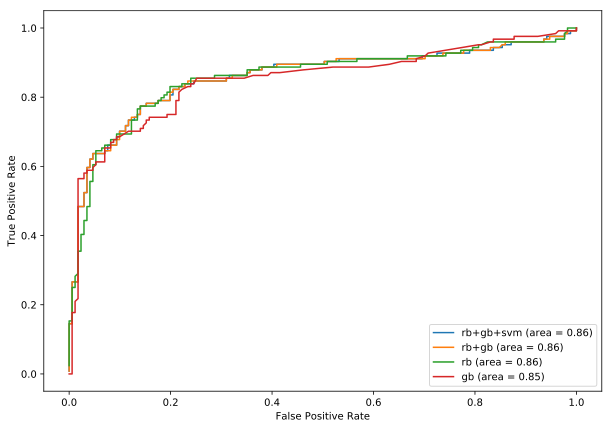

In [130]:
from sklearn.metrics import roc_curve, roc_auc_score

model1 = LogisticRegression(penalty='l1', C=0.3).fit(X_train_, Y_train)  # лучший результат
predictions1 = model1.predict_proba( X_test_)

#class_weight = 'balanced'
#print(X_train_[1:3,:])

model2 = LogisticRegression(penalty='l1', C=0.3).fit(X_train_[:,:2], Y_train) # лучший результат
predictions2 = model2.predict_proba( X_test_[:,:2])

#print(X_train_[1:3,:2])

model3 = LogisticRegression(penalty='l1', C=0.3).fit(X_train_[:,:1],Y_train)  # лучший результат
predictions3 = model3.predict_proba( X_test_[:,:1])

#print(X_train_[1:3,:1])

model4 = LogisticRegression(penalty='l1', C=0.3).fit(X_train_[:,1:2],Y_train)  # лучший результат
predictions4 = model4.predict_proba( X_test_[:,1:2])

#print(X_train_[1:3,1:2])

fpr1, tpr1, tr1 = roc_curve( Y_test, predictions1[:,1] )
s1=roc_auc_score(Y_test, predictions1[:, 1])

fpr2, tpr2, tr2 = roc_curve( Y_test, predictions2[:,1] )
s2=roc_auc_score(Y_test, predictions2[:, 1])

fpr3, tpr3, tr3 = roc_curve( Y_test, predictions3[:,1] )
s3=roc_auc_score(Y_test, predictions3[:, 1])

fpr4, tpr4, tr4 = roc_curve( Y_test, predictions4[:,1] )
s4=roc_auc_score(Y_test, predictions4[:, 1])


plt.plot( fpr1, tpr1, label = 'rb+gb+svm (area = %0.2f)' % s1 )
plt.plot( fpr2, tpr2, label = 'rb+gb (area = %0.2f)' % s2 )
plt.plot( fpr3, tpr3, label = 'rb (area = %0.2f)' % s3 )
plt.plot( fpr4, tpr4, label = 'gb (area = %0.2f)' % s4 )

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend( loc = 0 )
plt.show()

In [131]:
# отправим в Kaggel для дальнейшего сравнения
TempCL = LogisticRegression(penalty='l1', C=0.3).fit(X_train_stack, Y)  # лучший результат
predicted = TempCL.predict(X_test_stack)


with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))

# Выводы и промежуточные итоги

In [ ]:
# RandomForestClassifier(max_features=7,max_depth=8, n_estimators=85) -  0.79426
# RandomForestClassifier(max_features=7,max_depth=8, n_estimators=85) - 0.78947
# RandomForestClassifier(max_features=7,max_depth=8, n_estimators=158) - 0.77990

# GradientBoostingClassifier(max_features=0.5,max_depth=6, n_estimators=25, min_samples_leaf=1) - 0.78947
# GradientBoostingClassifier(n_estimators=24) - 0.80861 ???  пожалуй пораметры трогарть не надо ;-)